In [1]:
import pandas as pd
import os
import warnings
from utils.meli_data_extract import ETL
from utils.meli_model_2 import KMeansPipeline as kmp
from utils import meli_eda as eda
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# 1. Extracción de datos  

En esta sección se extraen los items de todas las categorías encontradas del país seleccionado, en este caso Colombia, luego se trae la información de todos los sellers encontrados en los items. Más detalles en meli_data_extract.py  



La instancia de la ETL puede cargar datos de cualquier país, solo basta con escribir las iniciales del país.  
Tambien se puede usar data precargada para no descargar la data de la API (puede tardar hasta 1 hora), para esto debe descomprimir el raw_data.zip en ./raw_data/  
preload_data = True

In [2]:
# Instanciar la clase ETL con 'col' como country_name
etl = ETL(country_name='col')
preload_data = False
# Ruta para guardar los resultados
output_dir = './output'
output_file = os.path.join(output_dir, 'data.csv')


In [ ]:
# Ejecutar el pipeline completo
try:
    df = etl.run_pipeline(preload_data=preload_data)
    # Crear la carpeta si no existe
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Carpeta creada: {output_dir}")

    # Guardar el resultado final en un archivo CSV
    df.to_csv(output_file, index=False)
    print(f"Datos finales guardados en '{output_file}'.")
except Exception as e:
    print(f"Ocurrió un error al ejecutar el pipeline: {e}")


Extrayendo datos de items desde la API...


# 2. Calidad de datos  
En esta sección se hará una limpieza profunda de los datos, validando la calidad de los mismos

Primero procedemos a seleccionar las columnas que pueden tener alguna utilidad analítica

In [5]:
list_analytics_columns = ['id','condition','listing_type_id','buying_mode','category_id','price','original_price',
    'available_quantity','accepts_mercadopago','sale_price_amount','sale_price_currency_id',
    'sale_price_payment_method_type','sale_price_type','shipping_free_shipping',
    'shipping_logistic_type','shipping_shipping_score','seller_id','address_state_name',
    'address_city_name','installments_quantity','installments_amount','seller_reputation_level_id',
    'seller_reputation_power_seller_status','seller_reputation_transactions_total','name',
    'sale_price_conditions_start_time','sale_price_conditions_end_time','sale_price_metadata_promotion_type'
    ]



Se buscan columnas a eliminar según varios algunos criterios  
*   99% de los datos son nulos.
*   Columnas con baja varianza cercana a 0.

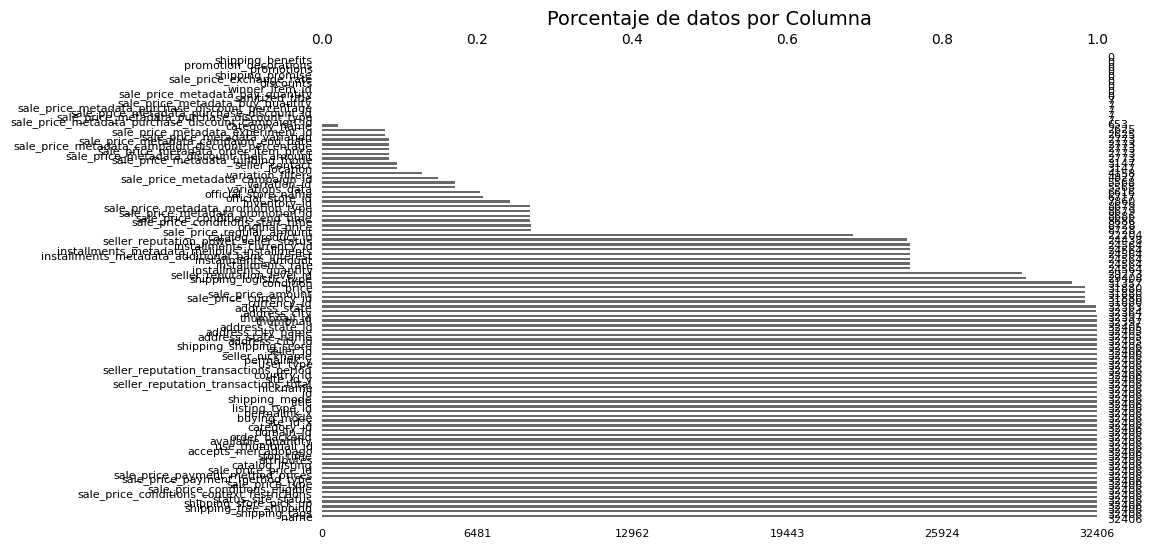

In [6]:
eda.missing_values_report(df)

In [7]:
list_null_cols = eda.get_columns_with_high_nulls(df,99)
list_unbalance_cetegory = eda.get_unbalanced_categories(df,95)
list_low_var = eda.get_low_variance_columns(df,0)

list_delete_cols = list_low_var + list_unbalance_cetegory + list_low_var

Columnas con más del 99% de valores nulos: ['sanitized_title', 'winner_item_id', 'discounts', 'promotion_decorations', 'promotions', 'sale_price_exchange_rate', 'sale_price_metadata_buy_quantity', 'sale_price_metadata_pay_quantity', 'sale_price_metadata_purchase_discount_percentage', 'sale_price_metadata_purchase_discount_id', 'sale_price_metadata_purchase_discount_type', 'sale_price_metadata_purchase_discount_campaign_id', 'shipping_benefits', 'shipping_promise']
Columnas categóricas desbalanceadas (umbral: 95%): ['site_id_x', 'currency_id', 'variation_filters', 'sale_price_price_id', 'sale_price_currency_id', 'sale_price_payment_method_prices', 'sale_price_payment_method_type', 'sale_price_conditions_eligible', 'sale_price_metadata_funding_mode', 'shipping_store_pick_up', 'installments_currency_id', 'installments_metadata_meliplus_installments', 'installments_metadata_additional_bank_interest', 'country_id', 'site_id_y', 'seller_reputation_level_id', 'seller_reputation_transactions_p

Se crea un dataframe inicial filtrado bajo los criterios planteados anteriormente

In [8]:
# Eliminar las columnas en list_delete_cols si existen en el DataFrame
df_filtered = df.drop(columns=[col for col in list_delete_cols if col in df.columns], axis=1)

# Seleccionar solo las columnas que están presentes en list_analytics_columns y el DataFrame filtrado
valid_columns = [col for col in list_analytics_columns if col in df_filtered.columns]
df_filtered = df_filtered[valid_columns]

Ahora una veamos los tipos de datos si hacen sentido y corregir de ser neecsario 

In [9]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32406 entries, 0 to 32405
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     32406 non-null  object 
 1   condition                              31357 non-null  object 
 2   listing_type_id                        32406 non-null  object 
 3   buying_mode                            32406 non-null  object 
 4   category_id                            32406 non-null  object 
 5   price                                  31880 non-null  float64
 6   original_price                         8728 non-null   float64
 7   available_quantity                     32406 non-null  float64
 8   accepts_mercadopago                    32406 non-null  object 
 9   sale_price_amount                      31880 non-null  float64
 10  sale_price_type                        32406 non-null  object 
 11  sh

Se hace correción del tipo de dato para las fechas

In [10]:
df_filtered['sale_price_conditions_start_time'] = pd.to_datetime(df_filtered['sale_price_conditions_start_time'])
df_filtered['sale_price_conditions_end_time'] = pd.to_datetime(df_filtered['sale_price_conditions_end_time'])

Eliminación de registros imposibles

In [11]:
df_filtered = df_filtered[
    (df_filtered['price'] > 0) &
    (df_filtered['available_quantity'] > 0) &
    ((df_filtered['sale_price_amount'] > 0) | (df_filtered['sale_price_amount'].isna())) &
    ((df_filtered['installments_quantity'] >= 0) | (df_filtered['installments_quantity'].isna())) &
    ((df_filtered['installments_amount'] >= 0) | (df_filtered['installments_amount'].isna())) &
    ((df_filtered['seller_reputation_transactions_total'] >= 0)| (df_filtered['installments_amount'].isna()))
]


Eliminación de registros duplicados

In [12]:
df_filtered = df_filtered.drop_duplicates()

Se hace una segunda vista de datos faltantes para crear estrategias para tratar con los datos faltantes

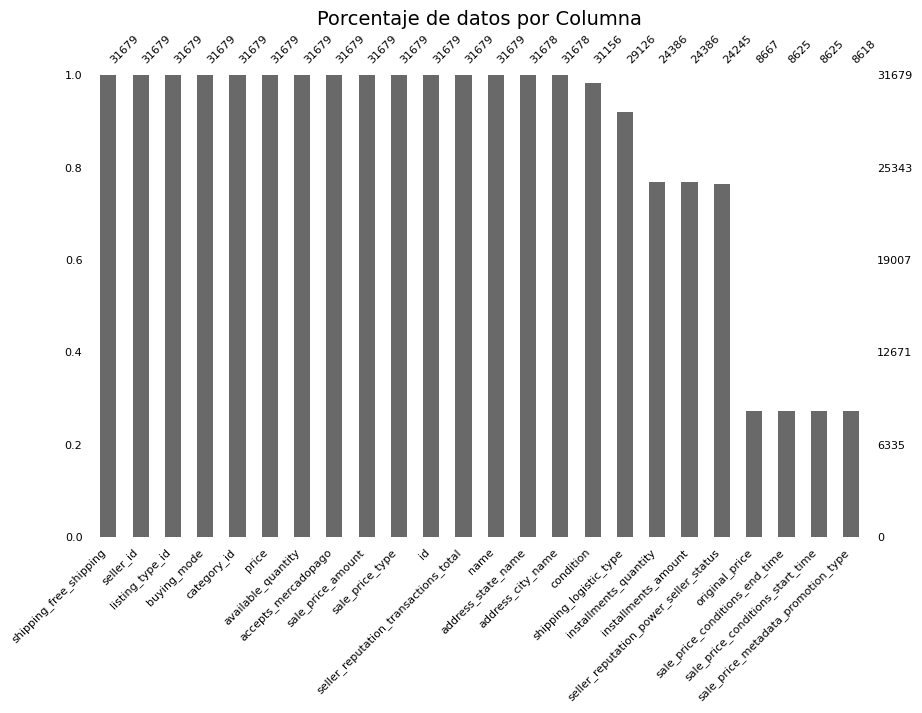

In [13]:
eda.missing_values_report(df_filtered)

Notemos que hay unos campos que se pueden completar desde el conocimiento del problema, como se muestra:  
*   installments_amount : se remplaza por 0 pues esto significa que no tiene metodo de pago a cuotas.  
*   installments_quantity : se remplaza por 0 pues esto significa que no tiene metodo de pago a cuotas. 
*   seller_reputation_powe_seller_status: imputar el dato vacio por "no_medal" , es decir no tiene medalla.  
*   original_price : se remplaza por price pues esto significa que no tiene descuento.  
*   sale_price_metadata_promotion_type: remplaza nulo por 'no_promotion'.  
*   shipping_logistic_type: se remplaza por 'unknown'.  

Así hay otros campos que se pueden completar imputando, como :
*   address_state_name: imputar con la moda.  
*   address_city_name: imputar con la moda.  
*   condition: imputar con la moda.  

Ahora crean algunas otras columnas que pueden ser utiles al momento de modelar los datos:
*   discount: 1 -(price/ original_price) *100 
*   flag_mercadopago : 1 si True, 0 si False, esto facilita trabajarlo.(eliminar accepts_mercadopago)  
*   flag_shipping_free_shipping : 1 si True, 0 si False, esto facilita trabajarlo.(eliminar flag_shipping_free_shipping) 
*   discount_days: sale_price_conditions_end_time - sale_price_conditions_start_time, rellenar los vacios con nulos. (eliminar sale_price_conditions_end_time y sale_price_conditions_start_time ) 
*   Finalmente se agrupan los datos por seller_id para que puedan ser consumidos por el modelo. 


In [14]:
df_final = eda.preprocess_data(df_filtered)
df_sellers = eda.build_sellers_data(df_final)

# 3. EDA  
En esta sección se busca tener una idea general de como es el comportamiento de los datos para así tener información suficiente del negocio y las posibles interpretaciones del modelo.

## 3.1 Gráficas varias  
Para más detalles de la interpretación de estas gráficas ir a la presentación.

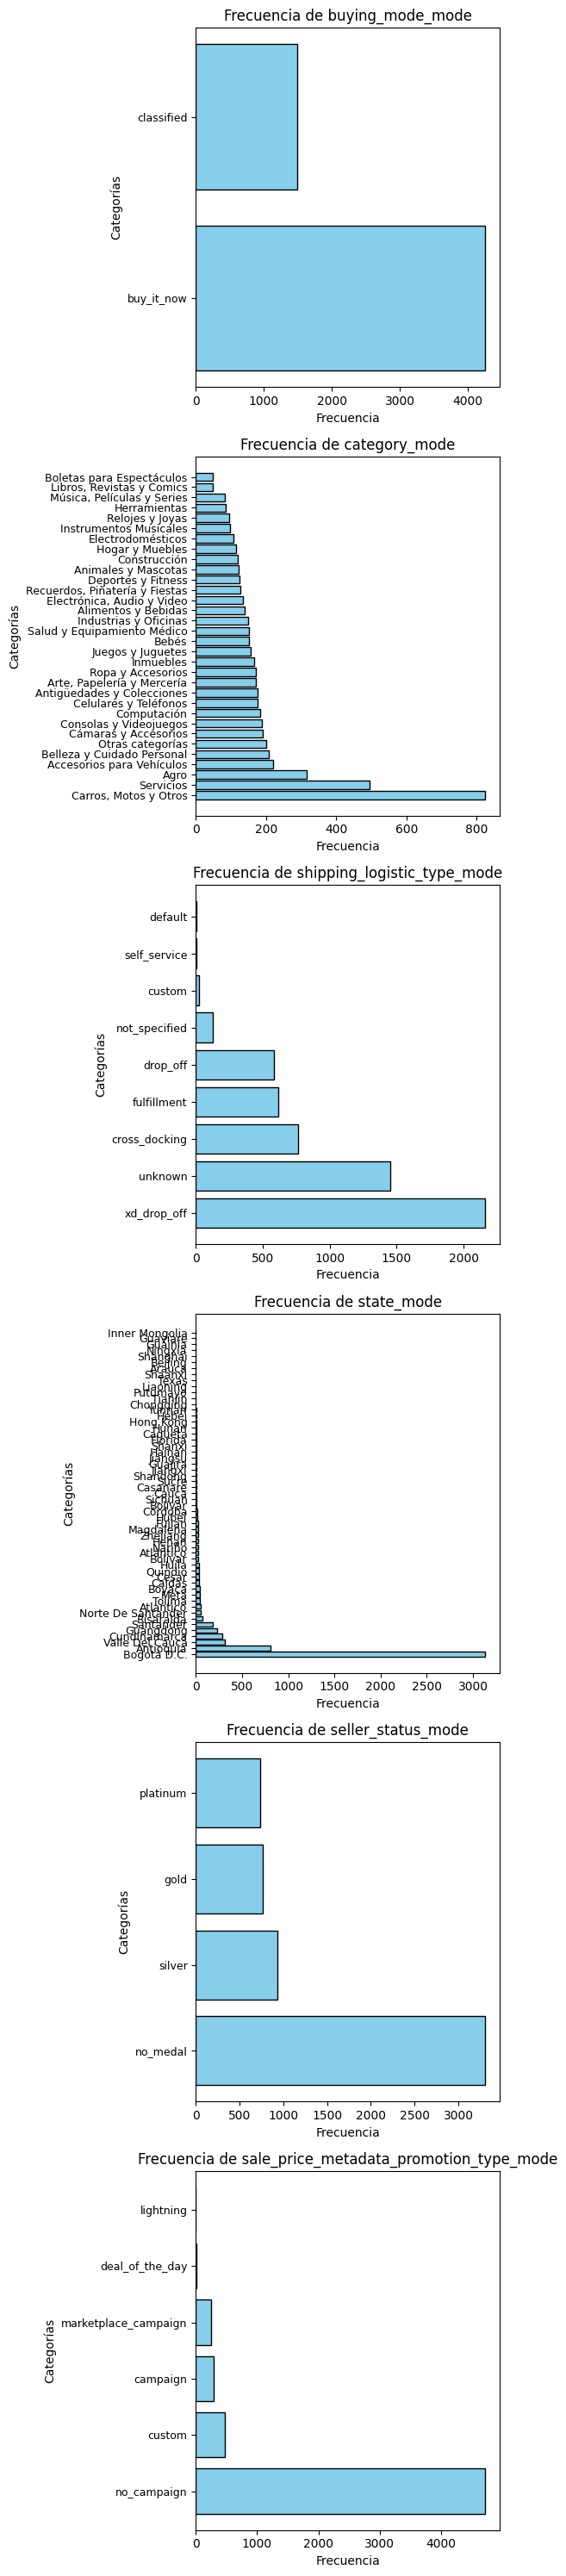

In [15]:
eda.plot_categorical_barcharts(df_sellers,max_cols_per_row=1)

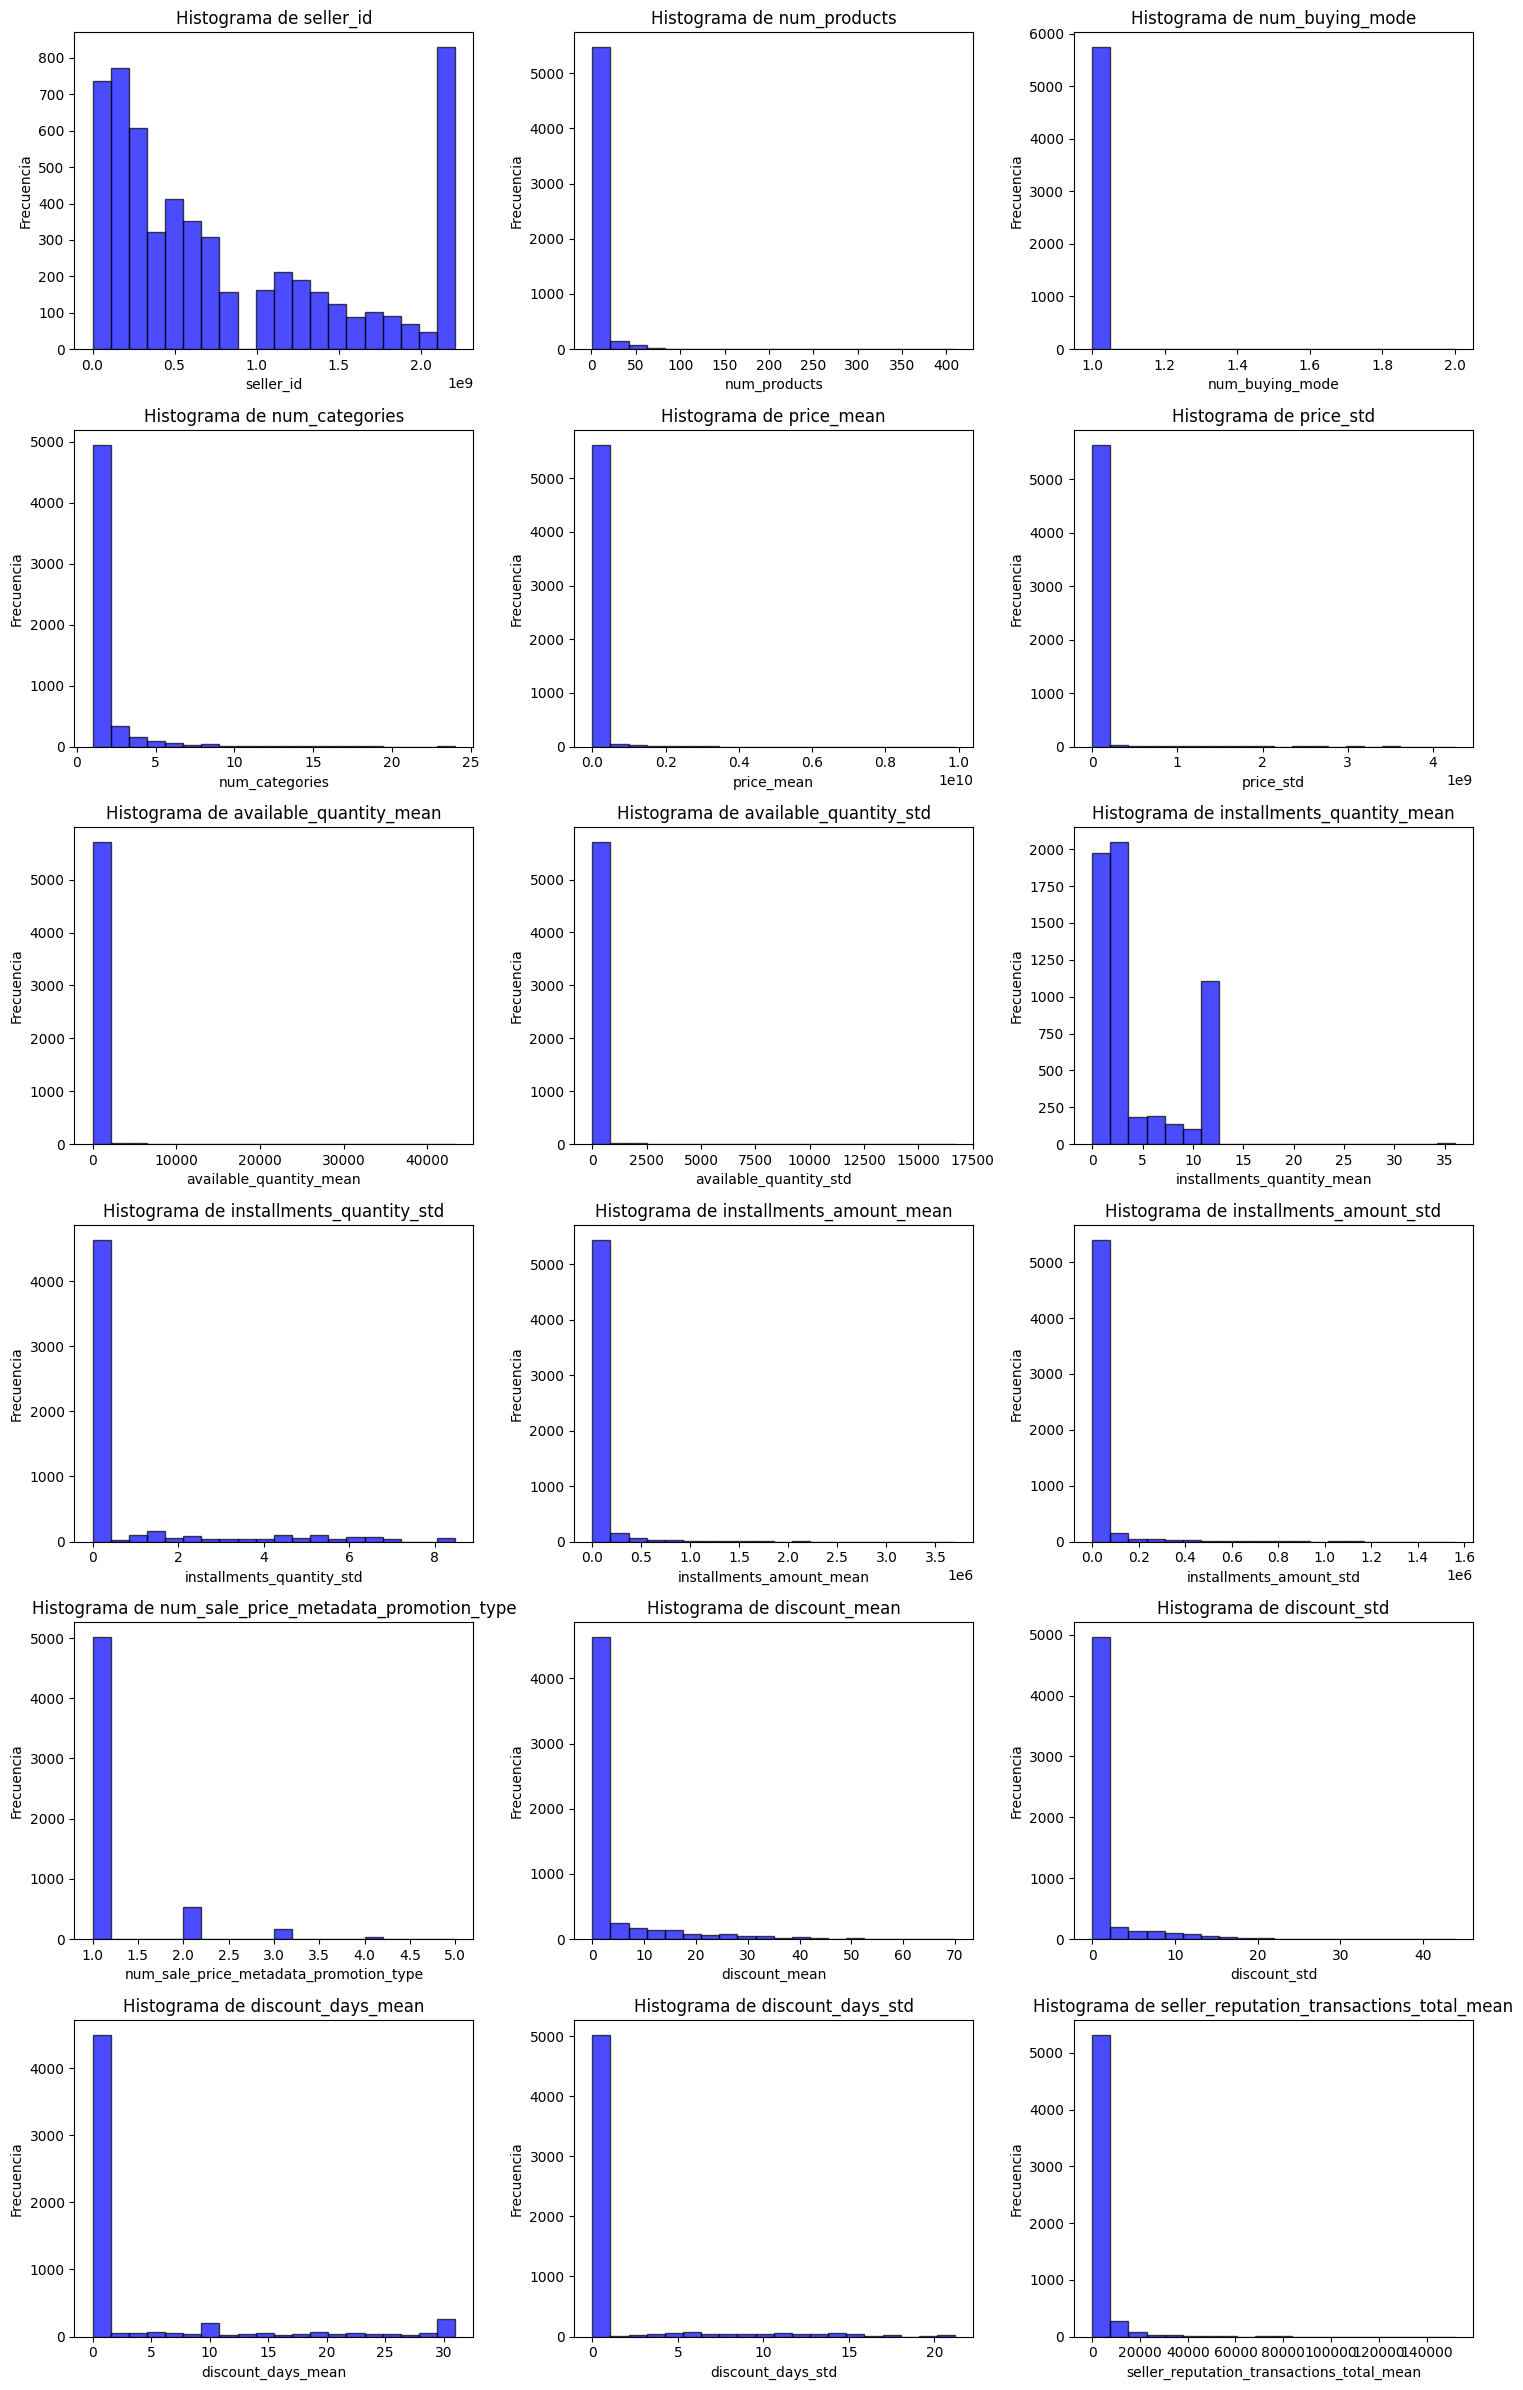

In [16]:
eda.plot_numeric_histograms(df_sellers,max_cols_per_row=3)

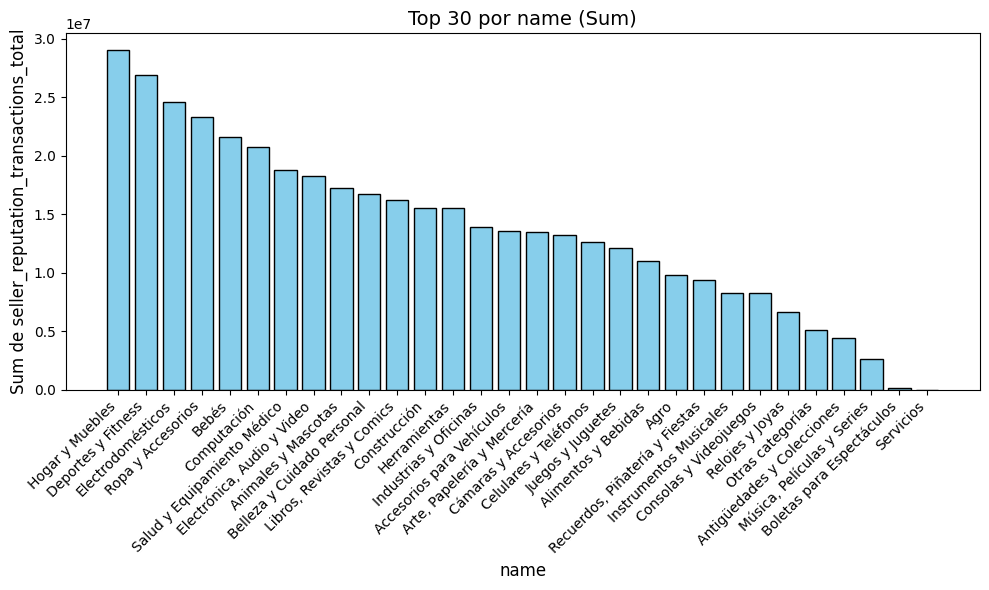

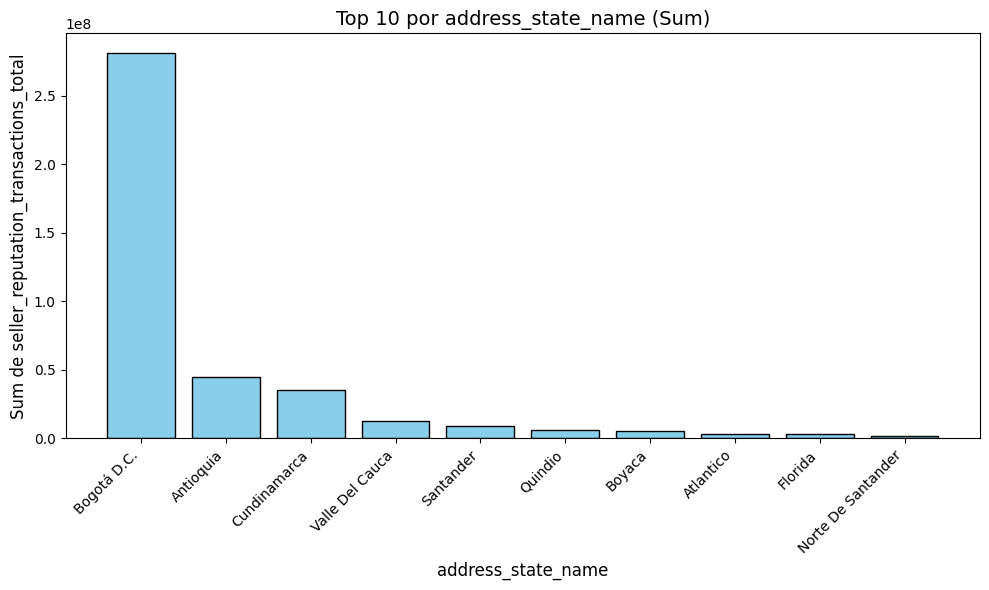

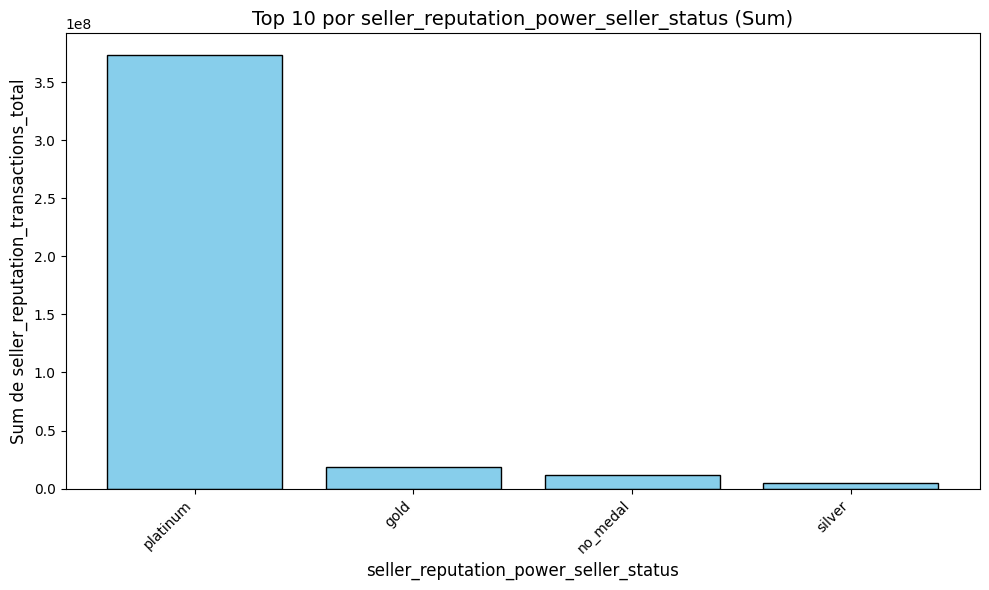

,seller_reputation_power_seller_status,seller_reputation_transactions_total
2,platinum,373287688
0,gold,18732038
1,no_medal,11865535
3,silver,5010940


In [17]:
eda.plot_top_grouped_data(df_final,['name'],'seller_reputation_transactions_total',agg_func='sum',top_n=30)
eda.plot_top_grouped_data(df_final,['address_state_name'],'seller_reputation_transactions_total',agg_func='sum',top_n=10)
eda.plot_top_grouped_data(df_final,['seller_reputation_power_seller_status'],'seller_reputation_transactions_total',agg_func='sum',top_n=10)

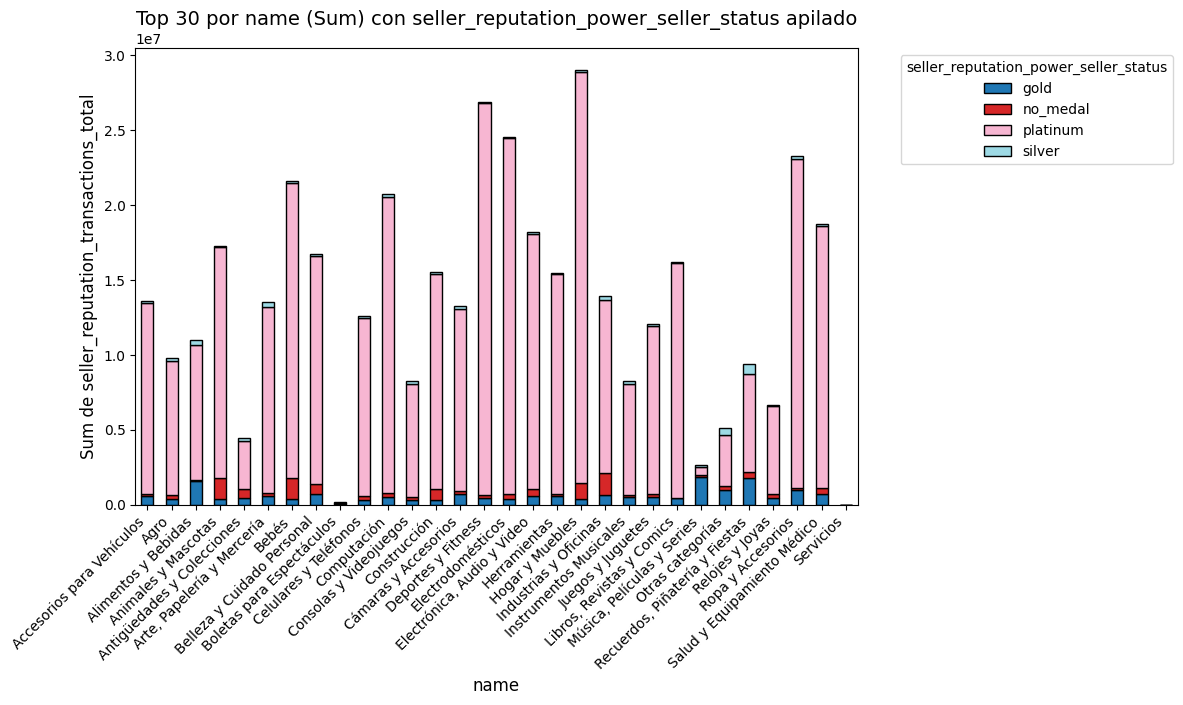

,name,seller_reputation_power_seller_status,seller_reputation_transactions_total
0,Accesorios para Vehículos,gold,578325
1,Accesorios para Vehículos,no_medal,129035
2,Accesorios para Vehículos,platinum,12730413
3,Accesorios para Vehículos,silver,125561
4,Agro,gold,408148
...,...,...,...
115,Salud y Equipamiento Médico,platinum,17482103
116,Salud y Equipamiento Médico,silver,162058
117,Servicios,gold,9978
118,Servicios,no_medal,2038


In [18]:
eda.plot_stacked_grouped_data(df_final, ['name','seller_reputation_power_seller_status'], value_column= 'seller_reputation_transactions_total', agg_func='sum', top_n = 30)

## 3.2 Matriz de correlación  
A partir de esta matriz se puede hace un ultimo ajuste de que variables pueden entrar al modelo, en este caso se busca que las variables no posean mucha correlación entre ellas.

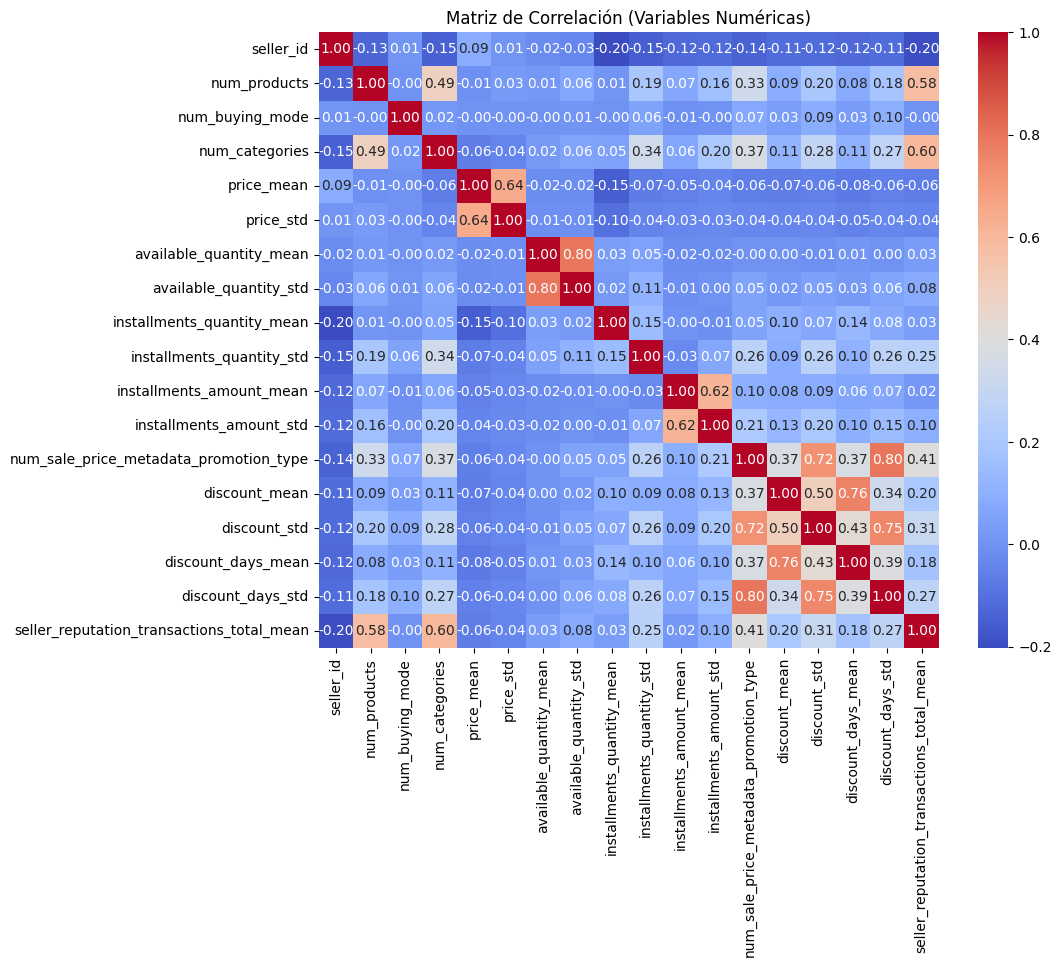

In [20]:
eda.plot_numeric_correlation(df_sellers)

Se listan las variables con alta correlación lineal para ser eliminadas posteriormente, pues afectan al desempeño de los grupos

In [21]:
list_drop_by_corr = [
    'num_sale_price_metadata_promotion_type',
    'discount_days_std',
    'installments_amount_std',
    'price_std',
    'available_quantity_std',
    'discount_days_mean'

]

Ahora basado en la siguiente tabla se procederá a listar las columnas que tengan baja varianza pues no aportaran al modelo

In [22]:
df_sellers.describe().T

,count,mean,std,min,25%,50%,75%,max
seller_id,5740.0,8.341259e+08,7.364390e+08,17434.0,2.086760e+08,5.562753e+08,1.361604e+09,2.211883e+09
num_products,5740.0,5.224390e+00,1.502716e+01,1.0,1.000000e+00,1.000000e+00,4.000000e+00,4.100000e+02
num_buying_mode,5740.0,1.000697e+00,2.639128e-02,1.0,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00
num_categories,5740.0,1.697735e+00,1.823859e+00,1.0,1.000000e+00,1.000000e+00,2.000000e+00,2.400000e+01
price_mean,5740.0,4.441152e+07,2.621186e+08,1400.0,5.249950e+04,1.303628e+05,8.500000e+05,9.900000e+09
price_std,5740.0,2.050322e+07,1.876985e+08,0.0,0.000000e+00,0.000000e+00,3.993900e+04,4.257624e+09
available_quantity_mean,5740.0,7.533712e+01,6.686341e+02,1.0,1.000000e+00,1.000000e+00,2.200000e+01,4.335714e+04
available_quantity_std,5740.0,3.356788e+01,2.954826e+02,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.669367e+04
installments_quantity_mean,5740.0,4.119865e+00,4.483143e+00,0.0,0.000000e+00,3.000000e+00,6.000000e+00,3.600000e+01
installments_quantity_std,5740.0,7.368702e-01,1.778630e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,8.485281e+00


# 4. Modelo Kmeans

En esta sección se procede a entrenar un modelo Kmeans, este modelo fue seleccionado por su facilidad de interpretar los resultados y escalabilidad, más detelles en la presentación.  
  
Para entrenar se usa el siguiente pipeline:  
1. se escalan los datos con un standar scaler y se guarda el escalador para poder ser usado con nuevos datos.  
2. Se genera la gráfica del método del codo para seleccinar los cluster.(El codo sugiere 6)  
3. Se entrena el modelo y se guarda para poder usarse con datos nuevos si es necesario.  
4. Se gráfican los centroides de los clusters, muy útil para interpretarlos.  
5. Asigar los clusters a la data originar.  

Notas:  
No olvidar asignar 6 clusters para reproducir los resultados


Escalador guardado en scaler.pkl


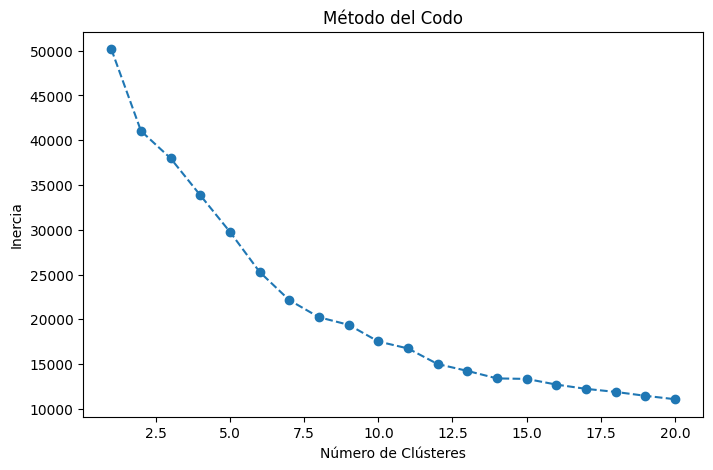

Se seleccionaron 6
Modelo KMeans guardado en kmeans_model.pkl


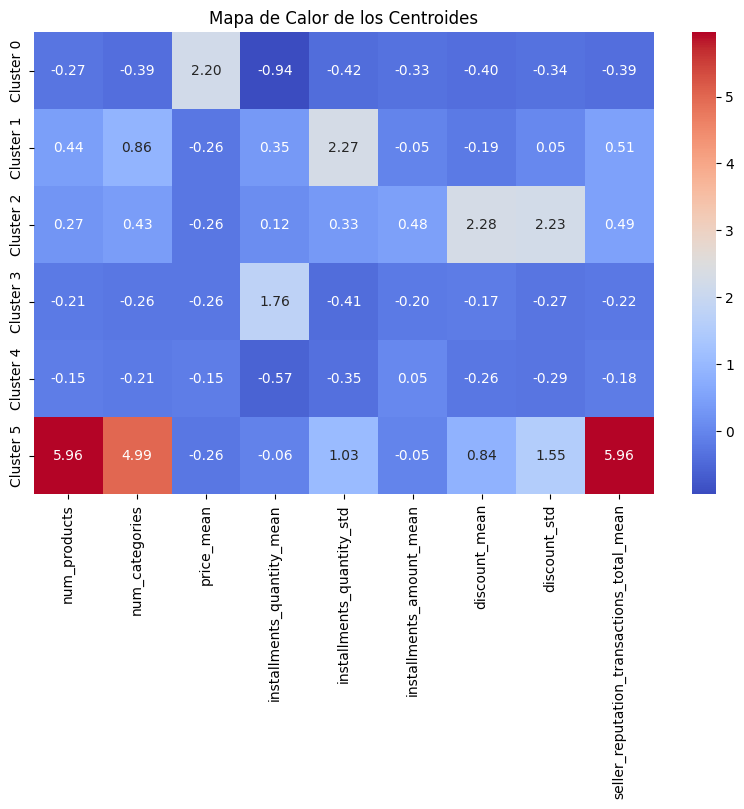

In [23]:
list_drop_by_var = ['seller_id','num_buying_mode','num_buying_mode','available_quantity_std','available_quantity_mean',]
list_drop_cols = list_drop_by_var + list_drop_by_corr
df_model = df_sellers.drop(list_drop_cols,axis=1)
df_model = df_model[df_model['category_mode']!='Inmuebles'] # Se eliminan los inmuebles pues sus precios pueden ser muy variables
kmeans_pipeline = kmp()
df_result = kmeans_pipeline.pipeline(df_model)

## Ahora se generan algúnas gráficas 
Estas gráficas serán usadas como sustento de la caracterización de los grupos en la presentación 

In [24]:

cluster_distribution = df_result['cluster'].value_counts().reset_index()
cluster_distribution.to_clipboard()

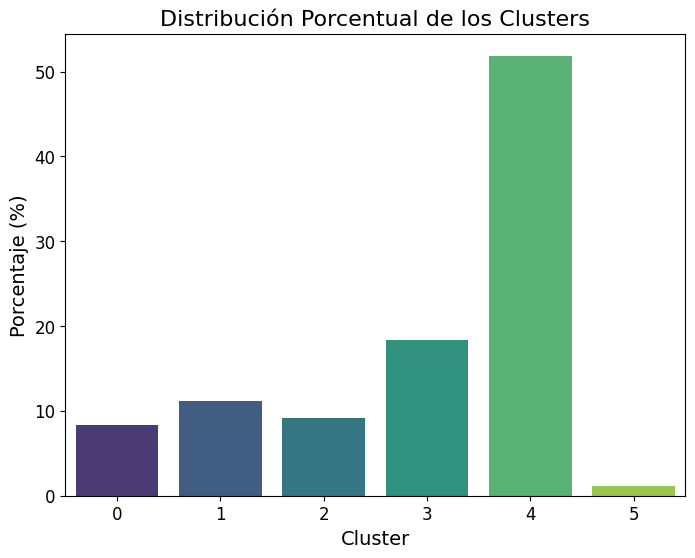

In [25]:

# Calcular la distribución porcentual
cluster_distribution = df_result['cluster'].value_counts(normalize=True) * 100
# Crear un DataFrame con la tabla de distribución
cluster_distribution_df = cluster_distribution.reset_index()
cluster_distribution_df.columns = ['Cluster', 'Porcentaje']

# Crear el barplot
plt.figure(figsize=(8, 6))
sns.barplot(x=cluster_distribution.index, y=cluster_distribution.values, palette="viridis")
plt.title("Distribución Porcentual de los Clusters", fontsize=16)
plt.xlabel("Cluster", fontsize=14)
plt.ylabel("Porcentaje (%)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [26]:
cluster_distribution_df

,Cluster,Porcentaje
0,4,51.865806
1,3,18.406889
2,1,11.176893
3,2,9.131683
4,0,8.306423
5,5,1.112307


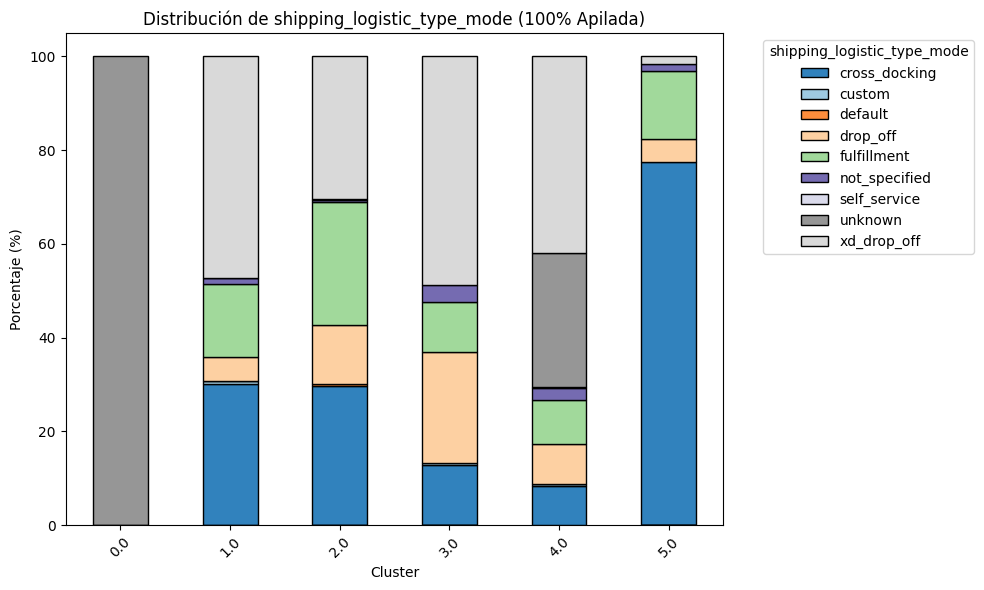

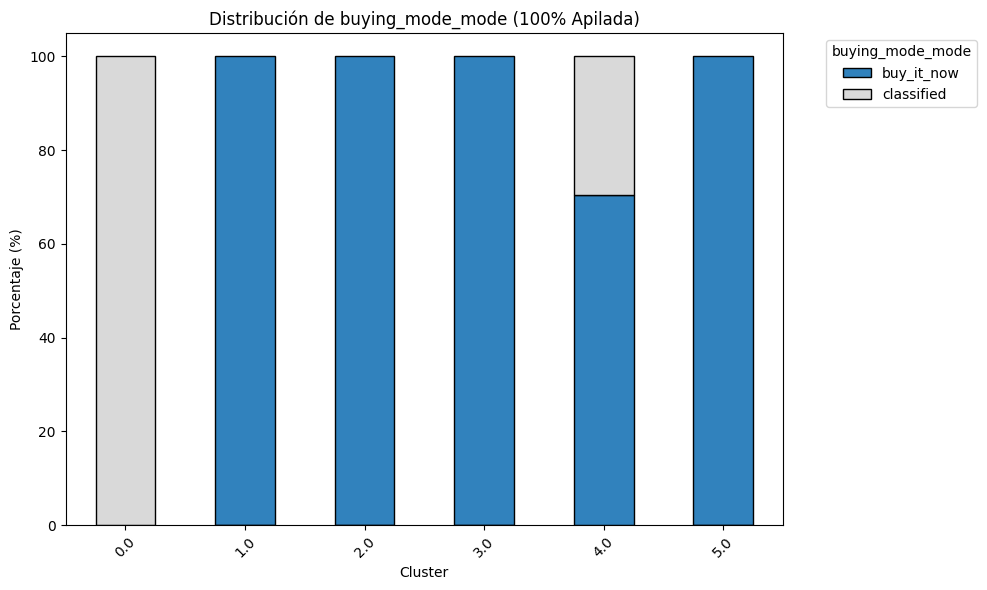

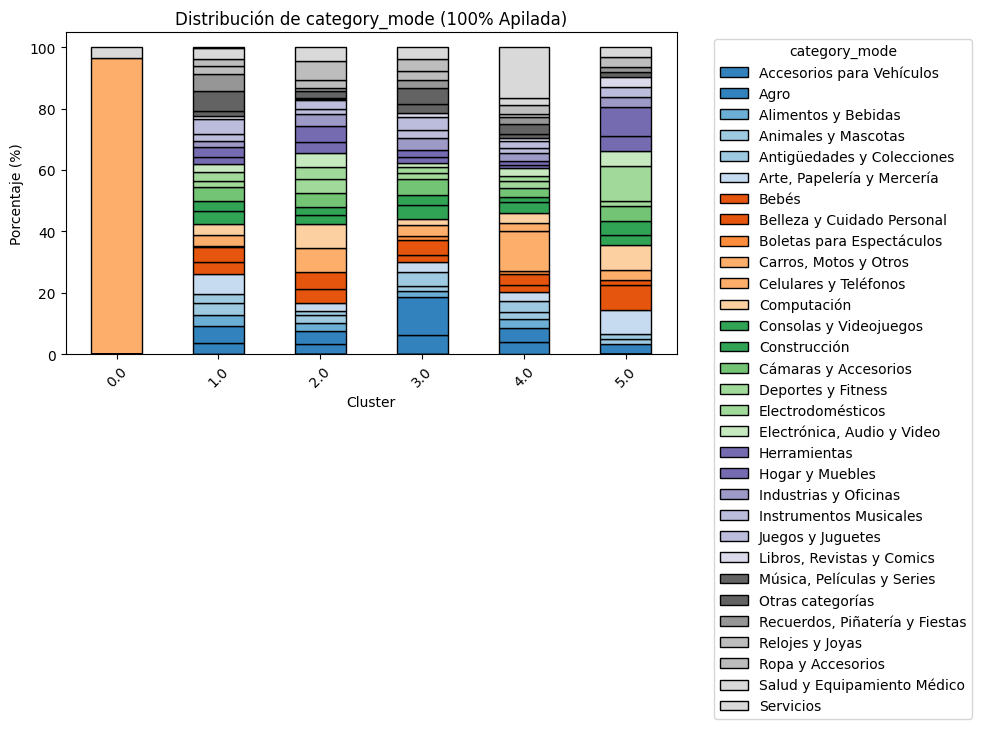

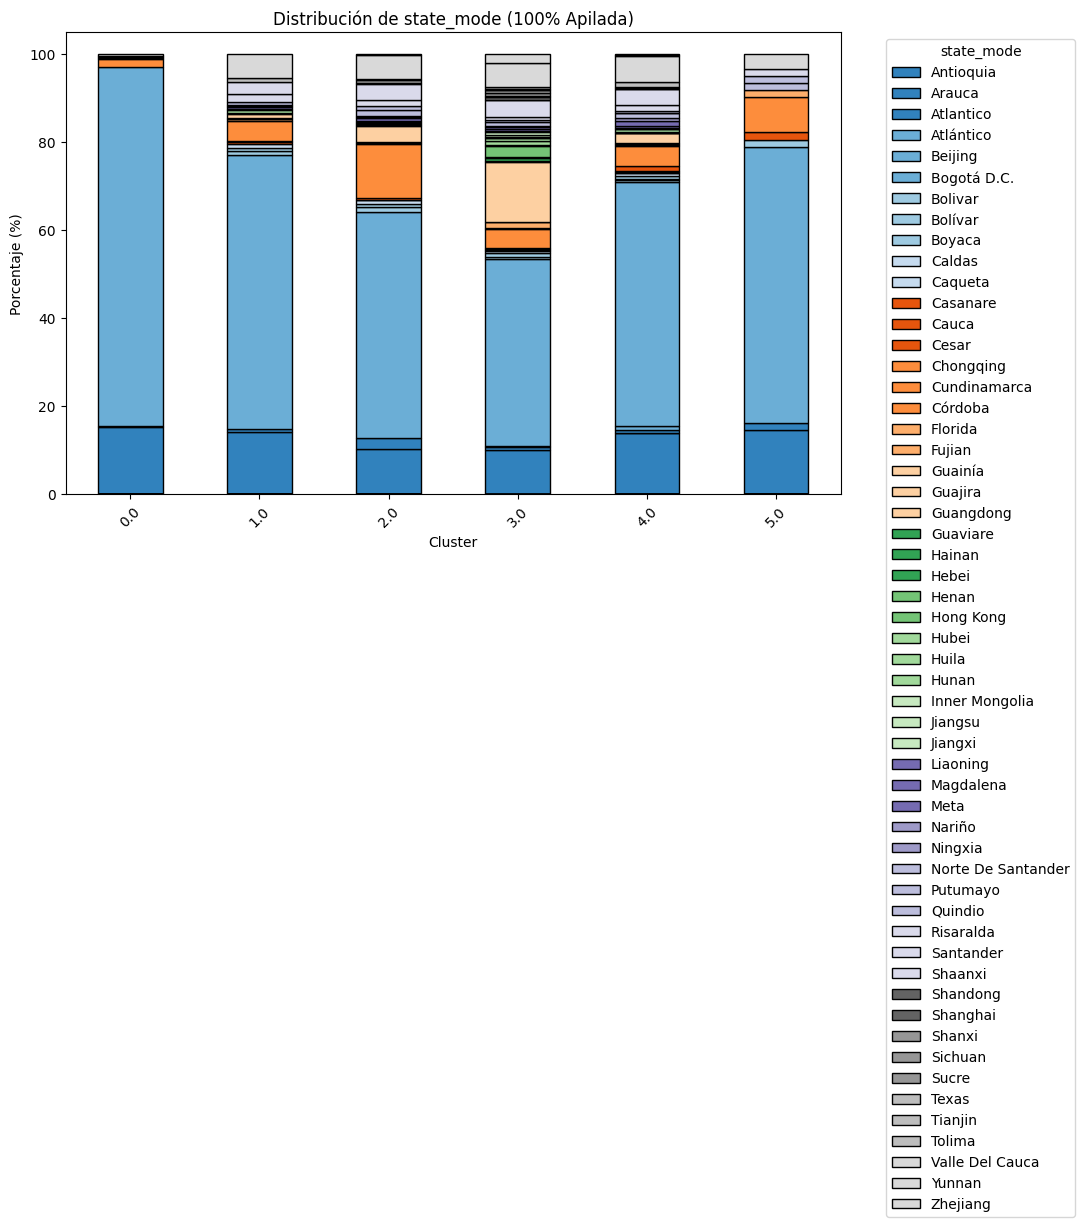

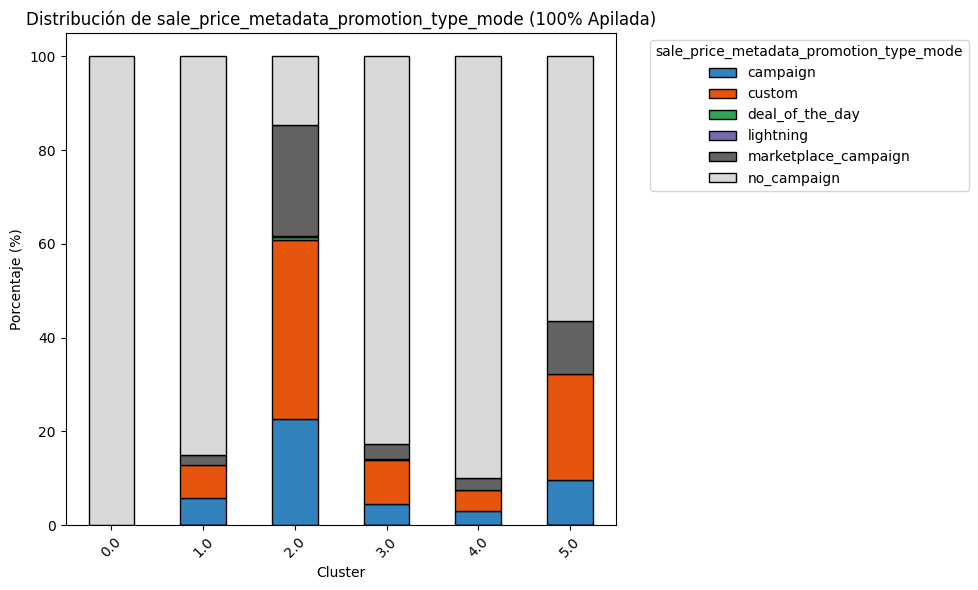

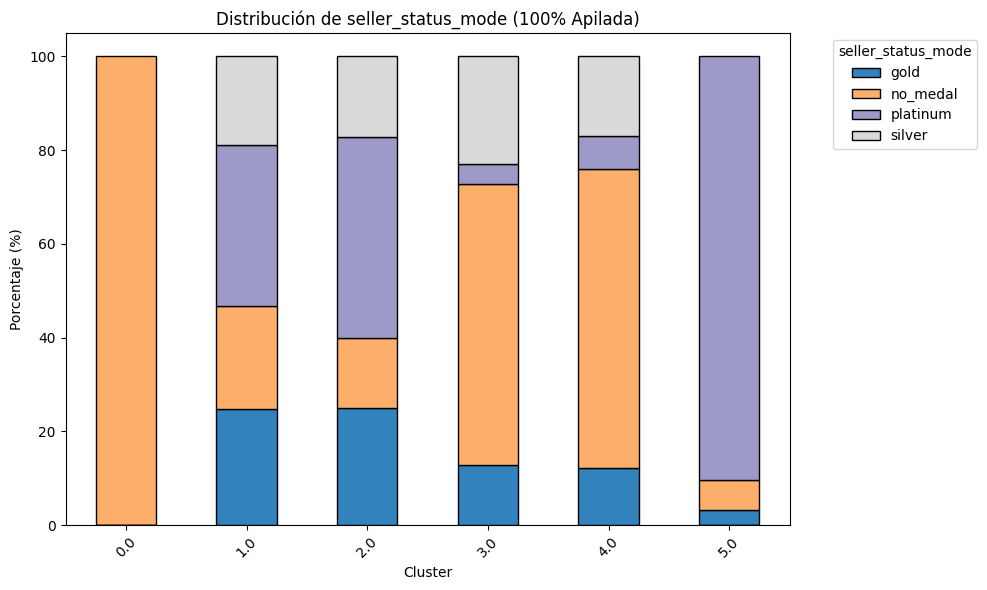

In [27]:
df_sellers_final = pd.concat([df_sellers,df_result['cluster']],axis=1)
eda.plot_stacked_bar(data=df_sellers_final, group_columns=['cluster', 'shipping_logistic_type_mode'])
eda.plot_stacked_bar(data=df_sellers_final, group_columns=['cluster', 'buying_mode_mode'])
eda.plot_stacked_bar(data=df_sellers_final, group_columns=['cluster', 'category_mode'])
eda.plot_stacked_bar(data=df_sellers_final, group_columns=['cluster', 'state_mode'])
eda.plot_stacked_bar(data=df_sellers_final, group_columns=['cluster', 'sale_price_metadata_promotion_type_mode'])
eda.plot_stacked_bar(data=df_sellers_final, group_columns=['cluster', 'seller_status_mode'])

# 5. Conclusiones

## 5.1 Caracterización de los grupos  
Nota: Los centroides 
* Grupo 0 Vendedor casual de celulares:  
    Tiene 8.30% de participación, principalmente venden celulares,manejan precios altos 2.2 desviaciones sobre la media y ofrecen número de  a cuotas  menores, 0.94 desviaciones por debajo, no tienen reputación y no tienen campañas de marketing. 
* Grupo 1 Emprendedores:    
    Tiene 11.17%, Es un seller que tiene una alta variedad de plazos de pago con 2.25 desviaciones sobre la media, tiene un catalogo ligeramente variado con 0.86 desviaciones, menos del 20% tiene campañas y cerca del 80% tienen medalla.  
* Grupo 2 Gancho por descuento :  
    Participación del 9.13%, más del 80% poseen campañas de marketing, cerca del 80% tienen medalla , destacan por ofrecer bastantes descuentos  donde tienen 2.2 desviaciones sobre la media aunque sus precios se diferencian mucho de los demas.
* Grupo 3 Pago cómodo:  
    Participación de 18.40%, tienen poca reputación pero suelen ofrecer facilidad de pago, con alto número de cuotas.  
* Grupo 4 Usuario común:  
    Tiene la mayor participación de los grupos con 51%.86, tienen poca reputación, cerca del 60% no tienen medalla.
* Grupo 5 Tienda establecida:  
    Son el 1.11% de los sellers, donde el número de productos , categorías y transacciones realizadas están sobre las 5 desviaciones arriba de la media y tienen buena reputación, donde mas del 90% tienen calificación platinum

## 5.2 Propuestas:  
* Grupo 4 Usuario común, Potencia tus Ventas: Enviar comunicaciones con tips de como ser mas atractivo en sus ventas y recordatorios de que puede poner más articulos a la venta.
* Grupo 5 Tienda establecida, fidelización: Dado que son los mejores sellers, darles incentivos para que se mantengan en el marketplace.
* Grupo 6 Vendedor casual de celulares, reputación : Campáñas de comunicación a estos sellers con tips de como mejorar su reputación dentro del market place y así impulsar sus ventas.
* Grupo 1 y 2  emprendedores: Aplicar una estrategia de recompra, es posible que los compradores no vean motivos volver a comprar o recomendar.    